# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.ToPILImage(),
                                       transforms.RandomRotation(degrees=(5,-5),fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)),
                                       # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation(degrees=(5,-5),fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)),
                                       
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([128, 1, 28, 28])
torch.Size([128])


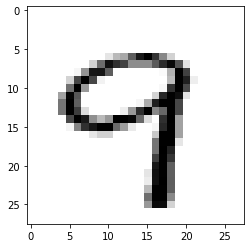

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
#train_data = train.transforms.ToPILImage()(train_data)
#train_data = train_transforms(transforms.ToPILImage()(train_data))
#train = Image.fromarray(train)
train_data = train.train_data


#train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

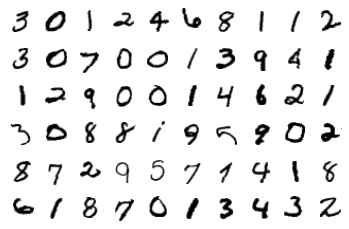

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=8),
            nn.Dropout2d(0.1)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            # nn.Dropout2d(0.1),
            nn.BatchNorm2d(num_features=16)
        ) # output_size = 26
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.Dropout2d(0.1),
            nn.BatchNorm2d(num_features=16)
        ) # output_size = 10
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.Dropout2d(0.1)
        ) # output_size = 10

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.Dropout2d(0.1),
            nn.BatchNorm2d(num_features=8)
        ) # output_size = 8
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(8,8), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
         Dropout2d-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 26, 26]             128
              ReLU-6           [-1, 16, 26, 26]               0
       BatchNorm2d-7           [-1, 16, 26, 26]              32
            Conv2d-8           [-1, 32, 24, 24]           4,608
              ReLU-9           [-1, 32, 24, 24]               0
      BatchNorm2d-10           [-1, 32, 24, 24]              64
        MaxPool2d-11           [-1, 32, 12, 12]               0
           Conv2d-12            [-1, 8, 12, 12]             256
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

train_losses = []
test_losses = []
train_acc = []
test_acc = []
#scheduler = StepLR(optimizer,step_size=6,gamma=0.1)

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

---



In [10]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer,step_size=6,gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.036038219928741455 Batch_id=468 Accuracy=95.06: 100%|██████████| 469/469 [00:16<00:00, 29.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9858/10000 (98.58%)

EPOCH: 1


Loss=0.04439661279320717 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9882/10000 (98.82%)

EPOCH: 2


Loss=0.020775333046913147 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.011425040662288666 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.030795997008681297 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.01453643012791872 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9921/10000 (99.21%)

EPOCH: 6


Loss=0.01012359093874693 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 28.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.06536420434713364 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:16<00:00, 28.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.004714906215667725 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.023237967863678932 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.02018221653997898 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.03044191561639309 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.010950490832328796 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.007984022609889507 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.03335680440068245 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]



Test set: Average loss: 0.0218, Accuracy: 9927/10000 (99.27%)



Text(0.5, 1.0, 'Test Accuracy')

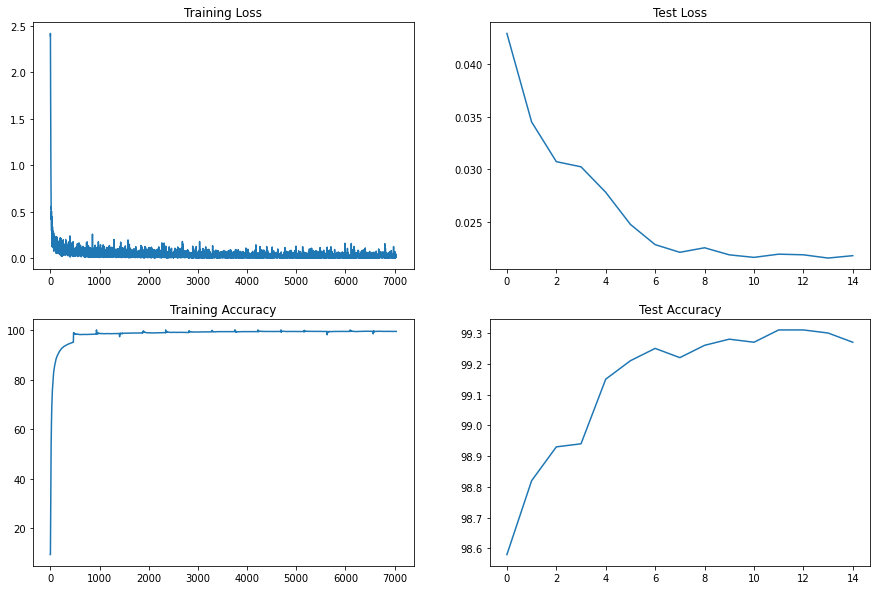

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")